# Further analysis on the MPI calibrations made on grvingt

In [1]:
import os
import numpy
import pandas
from extract_archive import extract_zip, aggregate_dataframe
archive_names = ['nancy_2018-07-24_1621460.zip']
alldf = []
aggr = []
for name in archive_names:
    archive = extract_zip(name)
    df = archive['exp/exp_Recv.csv']
    df['batch_index'] = numpy.floor(df.index / 10).astype(int)
    df['batch_index_mod'] = df.batch_index % 50 # 50 batches of 10 calls
    info = archive['info.yaml']
    deployment = str(info['deployment'])
    df['deployment'] = deployment
    mpi_version = set([info[key]['mpi'] for key in info.keys() if 'grid5000' in key])
    assert len(mpi_version) == 1
    mpi_version = mpi_version.pop()
    df['mpi'] = mpi_version
    df['exp_type'] = mpi_version + ' | ' + deployment
    alldf.append(df)
    aggr.append(aggregate_dataframe(df))
df = pandas.concat(alldf)
df_aggr = pandas.concat(aggr)
print(df.exp_type.unique())
df.head()

['mpirun (Open MPI) 2.0.2 | False']


,op,msg_size,start,duration,experiment,type,deployment,index,batch_index,batch_index_mod,mpi,exp_type
0,MPI_Recv,765921,0.003156,0.000077,nancy,exp/exp_Recv.csv,False,0,0,0,mpirun (Open MPI) 2.0.2,mpirun (Open MPI) 2.0.2 | False
1,MPI_Recv,765921,0.004077,0.000073,nancy,exp/exp_Recv.csv,False,1,0,0,mpirun (Open MPI) 2.0.2,mpirun (Open MPI) 2.0.2 | False
2,MPI_Recv,765921,0.004989,0.000073,nancy,exp/exp_Recv.csv,False,2,0,0,mpirun (Open MPI) 2.0.2,mpirun (Open MPI) 2.0.2 | False
3,MPI_Recv,765921,0.005903,0.000073,nancy,exp/exp_Recv.csv,False,3,0,0,mpirun (Open MPI) 2.0.2,mpirun (Open MPI) 2.0.2 | False
4,MPI_Recv,765921,0.006815,0.000073,nancy,exp/exp_Recv.csv,False,4,0,0,mpirun (Open MPI) 2.0.2,mpirun (Open MPI) 2.0.2 | False


In [2]:
%matplotlib inline
from plotnine import *
import plotnine; plotnine.options.figure_size = 12, 8
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

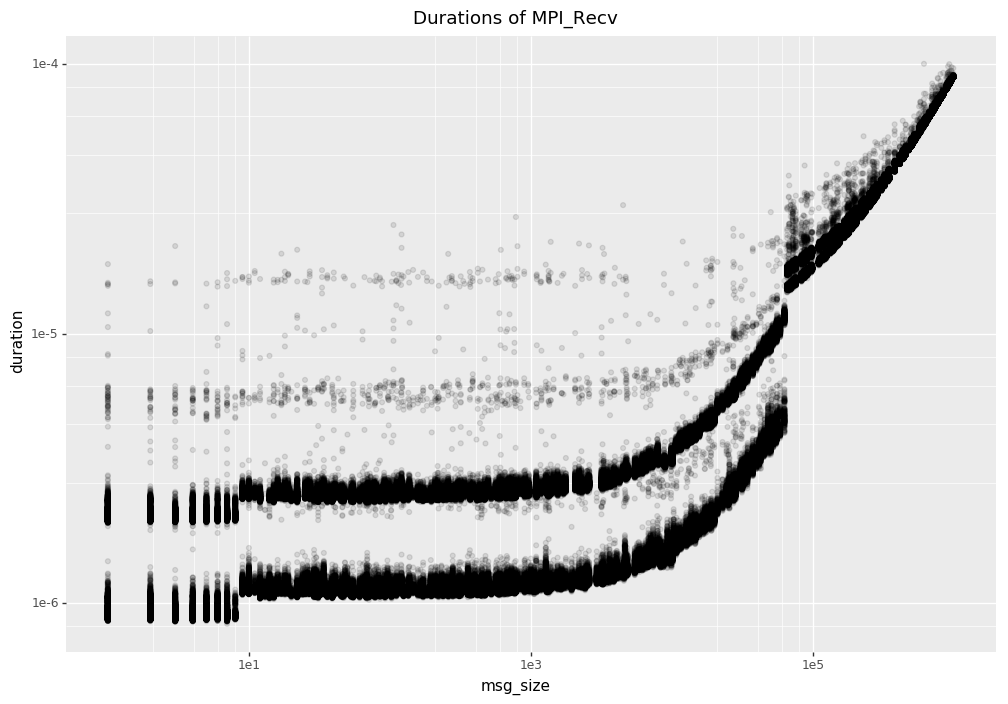

<ggplot: (-9223363284976410971)>

In [3]:
ggplot(df, aes(x='msg_size', y='duration')) + geom_point(alpha=0.1) + scale_x_log10() + scale_y_log10() + ggtitle('Durations of MPI_Recv')

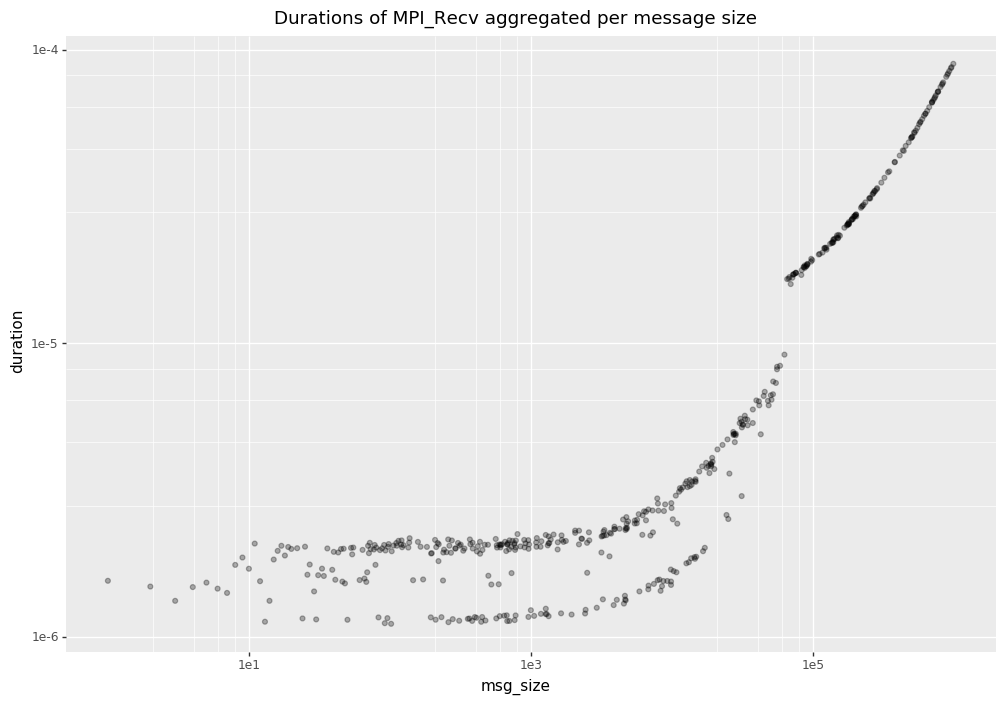

<ggplot: (8751877837930)>

In [4]:
ggplot(df_aggr, aes(x='msg_size', y='duration')) + geom_point(alpha=0.3) + scale_x_log10() + scale_y_log10() + ggtitle('Durations of MPI_Recv aggregated per message size')

Let's restrict ourselves to calls with a message size between 100 and 1000. We also manually partition the points into three groups, depending on the mean duration.

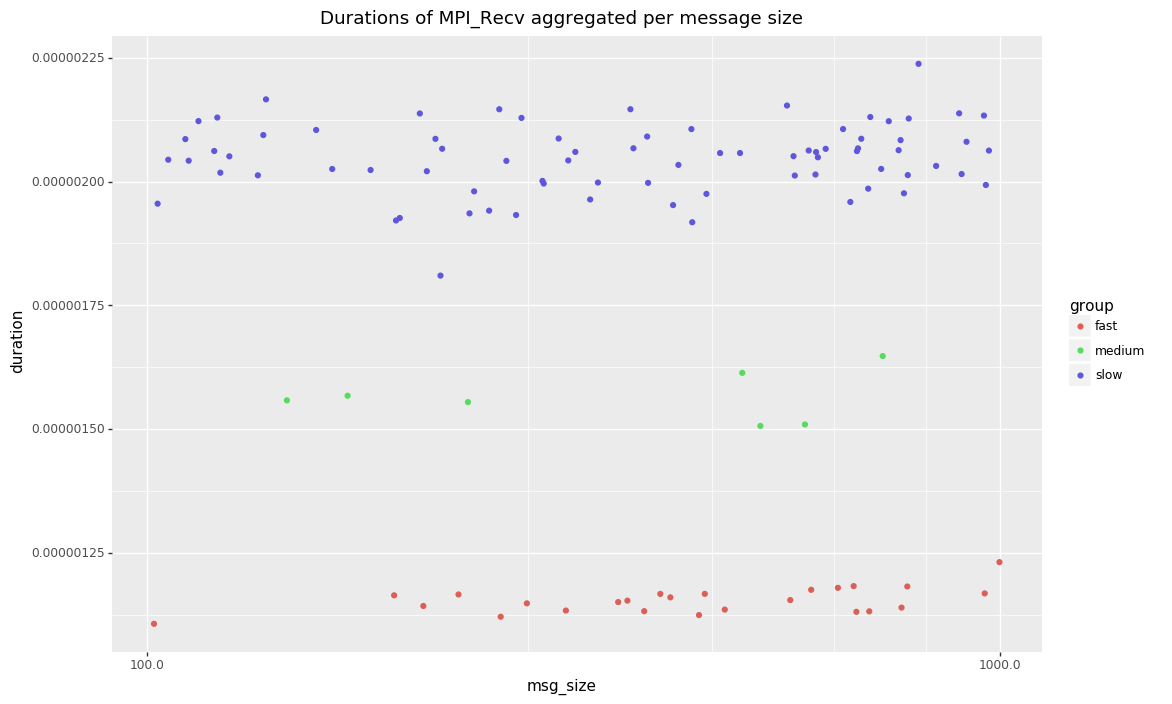

<ggplot: (-9223363284979062184)>

In [5]:
df = df[(df.msg_size >= 1e2) & (df.msg_size < 1e3)].copy() # gosh, I hate pandas' default
df_aggr = df_aggr[(df_aggr.msg_size >= 1e2) & (df_aggr.msg_size < 1e3)].copy()
df_aggr['group'] = 'medium'
df_aggr.loc[df_aggr.duration < 1.25e-6, 'group'] = 'fast'
df_aggr.loc[df_aggr.duration > 1.75e-6, 'group'] = 'slow'
ggplot(df_aggr, aes(x='msg_size', y='duration', color='group')) + geom_point() + scale_x_log10() + ggtitle('Durations of MPI_Recv aggregated per message size')

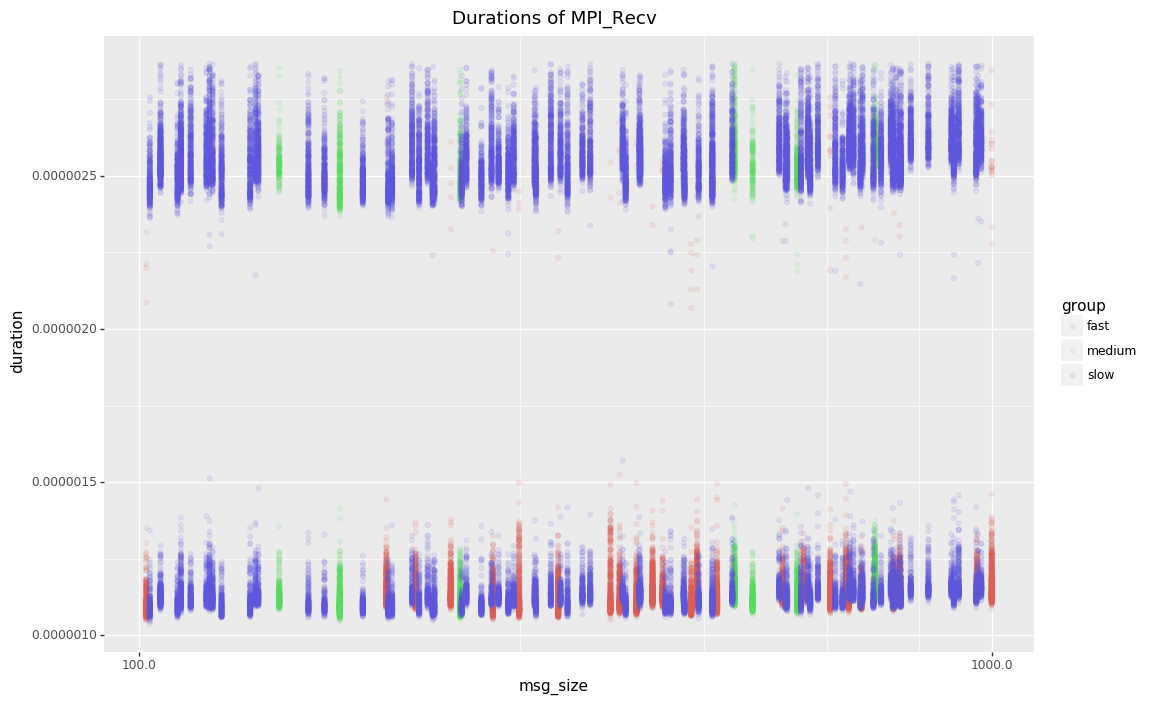

<ggplot: (-9223363284979062121)>

In [6]:
mapping = {row.msg_size: row.group for _, row in df_aggr.iterrows()}
df['group'] = df.apply(lambda row: mapping[row.msg_size], axis=1)
df = df[df.duration < df.duration.quantile(0.99)] # removing the extreme outliers...
ggplot(df, aes(x='msg_size', y='duration', color='group')) + geom_point(alpha=0.1) + scale_x_log10() + ggtitle('Durations of MPI_Recv')

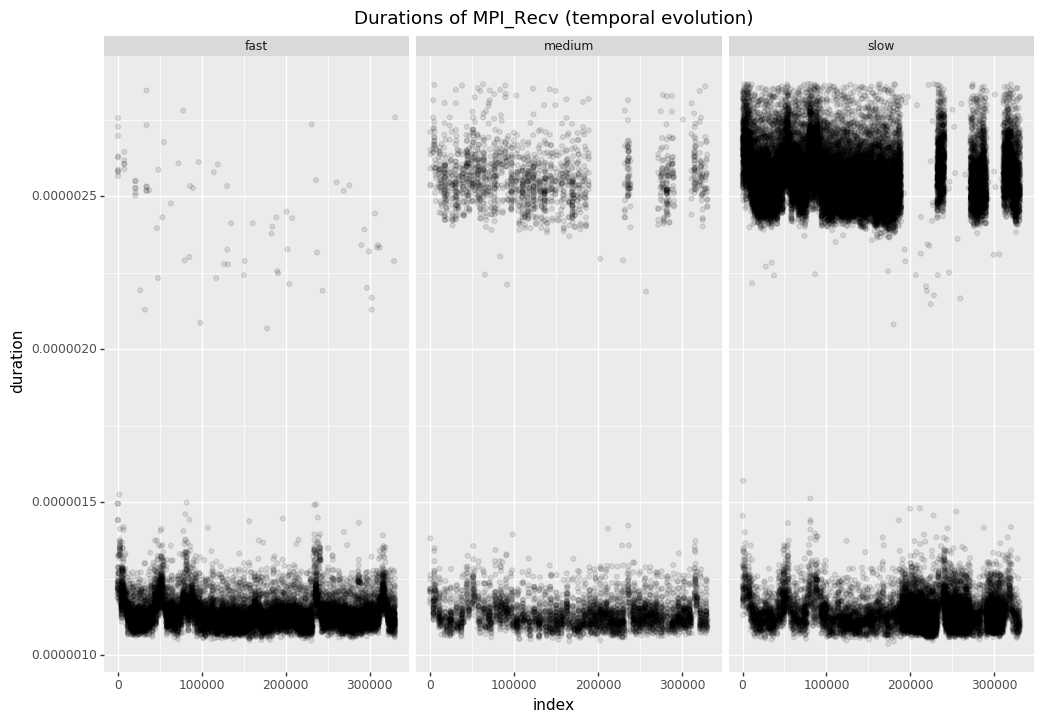

<ggplot: (8751874351799)>

In [7]:
ggplot(df, aes(x='index', y='duration')) + geom_point(alpha=0.1) + ggtitle('Durations of MPI_Recv (temporal evolution)') + facet_wrap('group')

In [8]:
for val in sorted(set(mapping.values())):
    print(val, [size for size, group in mapping.items() if group == val])
from collections import Counter
Counter(mapping.values())

fast [102, 195, 211, 232, 260, 279, 310, 357, 366, 383, 400, 411, 444, 451, 476, 568, 601, 646, 674, 679, 703, 767, 779, 960, 999]
medium [146, 172, 238, 499, 524, 591, 729]
slow [103, 106, 111, 112, 115, 120, 121, 122, 125, 135, 137, 138, 158, 165, 183, 196, 198, 209, 213, 218, 221, 222, 239, 242, 252, 259, 264, 271, 275, 291, 292, 304, 312, 318, 331, 338, 369, 372, 386, 387, 414, 420, 435, 436, 453, 470, 496, 563, 573, 575, 597, 608, 609, 612, 625, 655, 668, 680, 682, 688, 701, 705, 726, 741, 761, 765, 772, 780, 782, 803, 842, 896, 902, 914, 958, 963, 971]


Counter({'fast': 25, 'slow': 77, 'medium': 7})

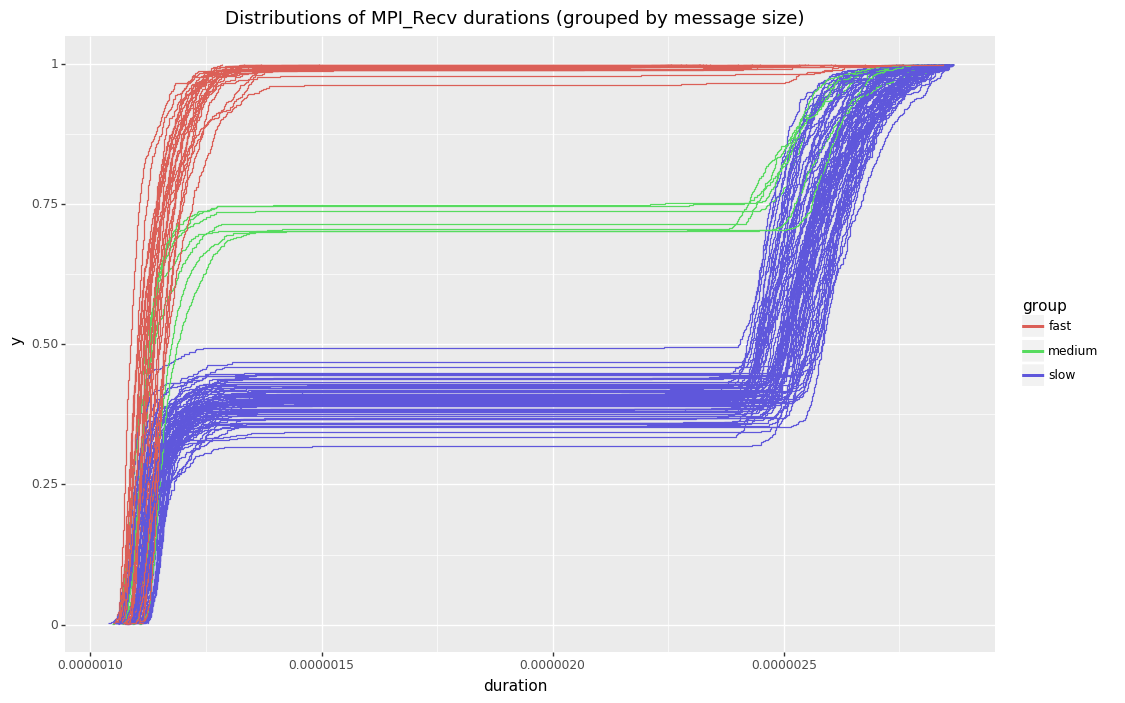

<ggplot: (8751878129174)>

In [9]:
ggplot(df, aes('duration', group='msg_size', color='group')) + stat_ecdf() + ggtitle('Distributions of MPI_Recv durations (grouped by message size)')

In [10]:
pandas.set_option('display.float_format', lambda x: '%.2e' % x)
df[['group', 'duration']].groupby('group').describe()

duration                                                               
          count     mean      std      min      25%      50%      75%      max
group                                                                         
fast   1.30e+04 1.15e-06 1.18e-07 1.05e-06 1.11e-06 1.13e-06 1.17e-06 2.84e-06
medium 5.46e+03 1.54e-06 6.42e-07 1.05e-06 1.11e-06 1.15e-06 2.46e-06 2.87e-06
slow   4.00e+04 2.00e-06 7.06e-07 1.04e-06 1.14e-06 2.49e-06 2.58e-06 2.87e-06

The calls to `MPI_Recv` can pretty clearly be partitionned into three groups:
- The `fast` group, with 25 different message sizes (out of 109). It has a low mean duration and a single mode.
- The `medium` group, with 7 different message sizes (out of 109). It has a medium mean duration and two modes: about 70% of its elements have a low duration.
- The `slow` group, with 77 different message sizes (out of 109). It has a high mean duration and two modes: about 40% of its elements have a low duration.